In [14]:
from playground_swing_rl.env.playground_swing import PlaygroundSwingEnv

In [ ]:
# Create your custom environment
env = PlaygroundSwingEnv()

# Wrap it with a time limit of steps per episode
env = TimeLimit(env, max_episode_steps=450)

In [6]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", env, verbose=1)

NameError: name 'env' is not defined

In [ ]:
model.learn(total_timesteps=200_000)  # Adjust as needed
# model.save("ppo_playground_swing")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 450      |
|    ep_rew_mean     | 199      |
| time/              |          |
|    fps             | 686      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 450         |
|    ep_rew_mean          | 193         |
| time/                   |             |
|    fps                  | 476         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005477974 |
|    clip_fraction        | 0.0228      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.00355    |
|    learning_rate        | 0.

450
Total reward: 423.5095343132714


Text(0.5, 1.0, 'toros speed')

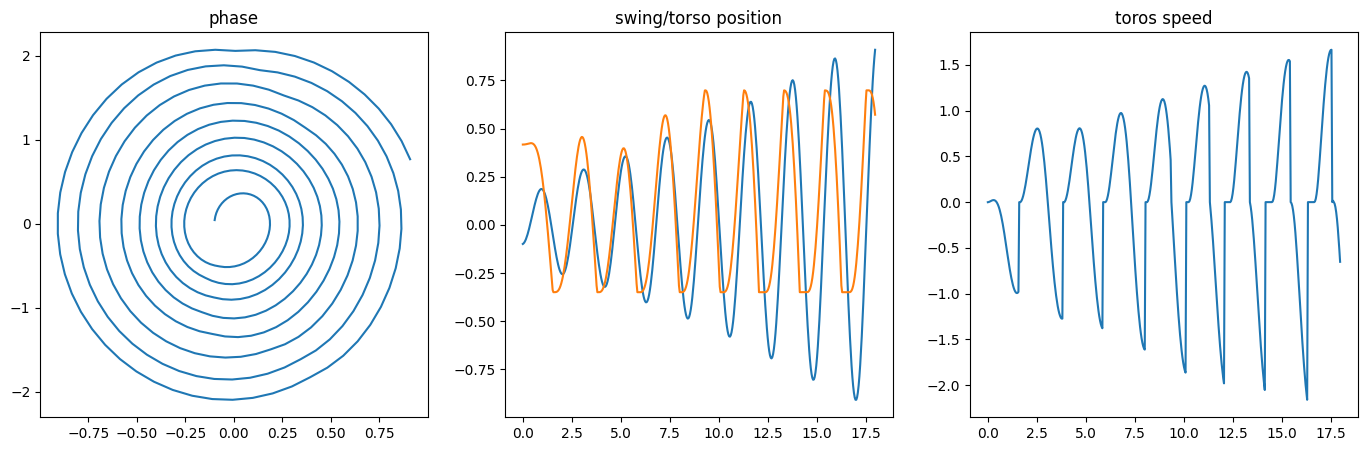

In [ ]:
obs, info = env.reset()
total_reward = 0
done = False
data = []
t = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
    data.append({'t': t, 'theta': obs[0], 'theta_dot': obs[1], 'phi': obs[2], 'psi': obs[4], 'phi_dot': obs[3]})
    t+=1/25
df = pd.DataFrame(data)
print(len(df))
print("Total reward:", total_reward)

fig, ax = plt.subplots(1,3, figsize = (17, 5))
ax[0].plot(df['theta'], df['theta_dot'])
ax[0].set_title('phase')
ax[1].plot(df['t'], df['theta'])
ax[1].plot(df['t'], df['phi'])
ax[1].set_title('swing/torso position')
ax[2].plot(df['t'], df['phi_dot'])
ax[2].set_title('toros speed')

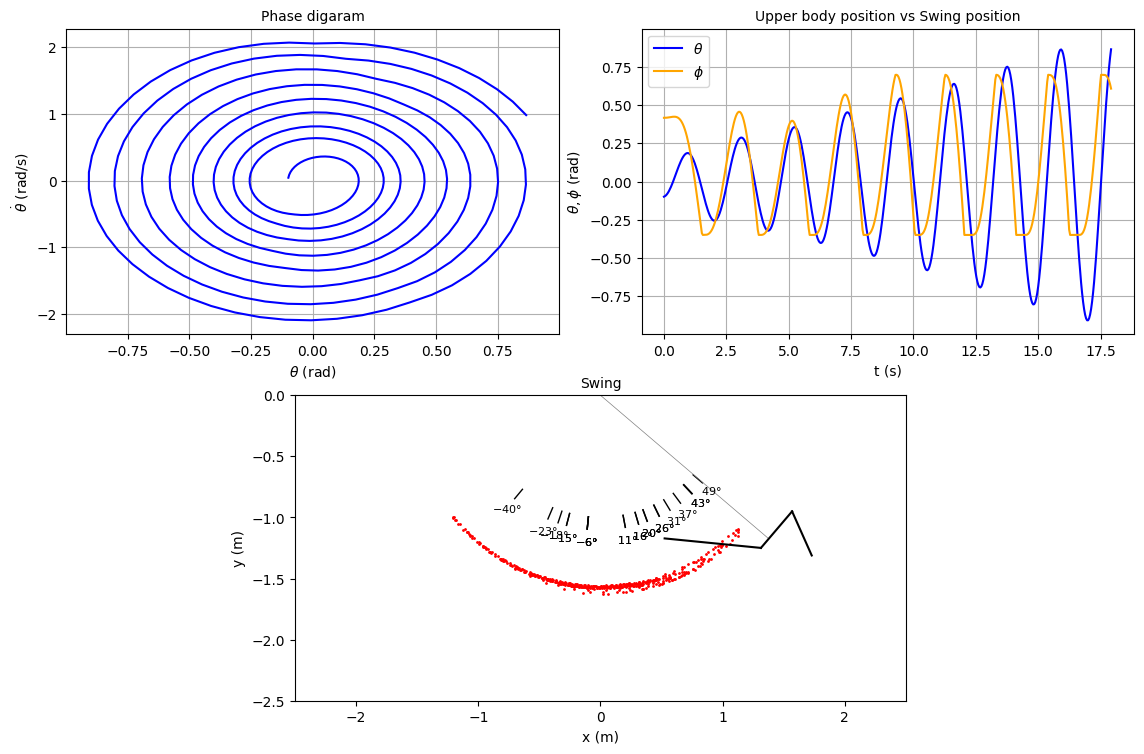

In [ ]:
import os
import sys
import argparse

from math import sin, cos, sqrt, pi
import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from swing_simulation.utils import RK4_for_2nd_order_ODE


def plot_theta(ax_, theta_):
      # drawing theta on plot with its value in degrees
      ax_.plot([1*sin(theta_),1.1*sin(theta_)], [-1*cos(theta_),-1.1*cos(theta_)], color='black', linewidth=1)
      ax_.text(1.2*sin(theta_), -1.2*cos(theta_), f'${np.degrees(theta_):.0f}\\degree$', fontsize=8, horizontalalignment="center", verticalalignment="center")
      
def plot_positions(ax_, theta_, phi_, psi_):
      # position of the butt
      p1 = np.array((L*sin(theta_) - a*cos(theta_), -L*cos(theta_) - a*sin(theta_)))
      # position of knees
      p2 = np.array((L*sin(theta_) + b*cos(theta_), -L*cos(theta_) + b*sin(theta_)))
      # position of head
      p3 = p1 + l1*np.array((-sin(theta_+phi_), cos(theta_+phi_)))
      # position of feet
      p4 = p2 + l3*np.array((sin(theta_+psi_), -cos(theta_+psi_)))
        
      swing_lines = []
      swing_lines.append(ax_.plot([0, L*sin(theta_)], [0, -L*cos(theta_)], color='grey', linewidth=0.5)[0])
      swing_lines.append(ax_.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black', linewidth=1.5)[0])
      swing_lines.append(ax_.plot([p1[0], p3[0]], [p1[1], p3[1]], color='black', linewidth=1.5)[0])
      swing_lines.append(ax_.plot([p2[0], p4[0]], [p2[1], p4[1]], color='black', linewidth=1.5)[0])
    
      # center of the mass
      mc1 = (p1+p3)/2
      mc2 = (p1+p2)/2
      mc3 = (p2+p4)/2
      CM = (m1*mc1 + m2*mc2 + m3*mc3 + M0*np.array((L/2*sin(theta_), -L/2*cos(theta_))))/(M+M0)
      red_dot = ax_.plot([CM[0]], [CM[1]], marker='o', markersize=1, color='red')[0]

      return swing_lines, red_dot

g = 9.8
t_step = 1/25

# drag coefficient
k = 0.4
k_prime = 7/3

# length and mass of swing
# L = 1.61
L = 1.81
# L = 2.01
M0 = 2 # base on google answer

# mass of swinger
m1 = 31.3
m2 = 12.3
m3 = 6.4
M = m1 + m2 + m3
# height of swinger
l1 = 0.792
l2 = 0.393
l3 = 0.395
# position of swinger on sit
a = (m2/2 + m3)*l2/M
b = (m1 + m2/2)*l2/M

# range of torso position
phi_mean = np.radians(10)
phi0 = np.radians(30)
# range of legs position (disregarded in paper because of significantly smaller than that of the upper body)
psi_mean = np.radians(10)
psi0 = np.radians(45)

# Moments of inertia
I = (M0/3 + M) * L**2
I_prime = (m1*l1**2 + m2*l2**2 + m3*l3**2)/3 + (m1*m3 - m2**2/4)*l2**2/M

N = (M0/2 + M)*L

if True:
      fig = plt.figure(figsize=(12, 8))
      ax = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=4)
      ax.set_aspect('equal')
      ax.set_xlim([-2.5,2.5])
      ax.set_ylim([-2.5,0])
      ax.set_xlabel('x (m)')
      ax.set_ylabel('y (m)')
      ax.set_title('Swing', fontsize='medium')
      fig.tight_layout()

      # phase diagram
      ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
      ax1.set_title('Phase digaram', fontsize='medium')
      ax1.set_xlabel(r'$\theta$ (rad)')
      ax1.set_ylabel(r'$\dot \theta$ (rad/s)')
      ax1.grid()

      phase_curve, = ax1.plot(df['theta'], df['theta_dot'], 'b')

      # angle plot
      ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
      ax2.set_title('Upper body position vs Swing position', fontsize='medium')
      ax2.set_xlabel('t (s)')
      ax2.set_ylabel(r'$\theta, \phi$ (rad)')
      ax2.grid()

      theta_curve, = ax2.plot(df['t'], df['theta'], 'blue', label=r'$\theta$')
      phi_curve, =  ax2.plot(df['t'], df['phi'], 'orange', label=r'$\phi$')

      plt.subplots_adjust(left=0.08, right=0.97, top=0.92, bottom=0.08, wspace=0.4, hspace=0.5)

      swing_lines  = [None]
      red_dot = [None]

      def animate(i):
          # Remove old swing lines, but not the red dot
          if swing_lines[0] is not None:
              for line in swing_lines[0]:
                  line.remove()
          # Clear plot after cycle
          if df['theta_dot'][i] == 0 and i>0:
              ax.clear()
              ax.set_aspect('equal')
              ax.set_xlim([-2.5,2.5])
              ax.set_ylim([-2.5,0])
              ax.set_xlabel('x (m)')
              ax.set_ylabel('y (m)')
              ax.set_title('Swing', fontsize='medium')

          if round(df['theta_dot'][i],1) == 0 or (df['theta_dot'][i]>0 and df['theta_dot'][i+1]<0):
                plot_theta(ax, df['theta'][i])
      
          phase_curve.set_data(df['theta'][:i+1], df['theta_dot'][:i+1])
      
          theta_curve.set_data(df['t'][:i+1], df['theta'][:i+1])
          phi_curve.set_data(df['t'][:i+1], df['phi'][:i+1])
          ax2.legend()
      
          swing_lines[0], red_dot[0]  = plot_positions(ax, df['theta'][i], df['phi'][i], df['psi'][i])
          return swing_lines[0] + [red_dot[0]]

      ani = FuncAnimation(fig, animate, frames=len(df)-1, interval=1000*t_step, blit=True)
      # Save as GIF using PillowWriter
      ani.save(f'agent105_t{t_step:.1g}.gif', writer=PillowWriter(fps=1/t_step))
